In [3]:
import numpy as np
import pandas as pd

### Set up matplotlib how we like it ###
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['legend.fontsize'] = 16

%matplotlib inline

In [4]:
### Import the relevant packages from Keras to be able to build our model ###
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.layers.core import Dense, Dropout, Flatten, Activation

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import keras

/Users/chris.morris/DSApplications/anaconda2/envs/tensorflowhack/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Explore the MNIST dataset

In [5]:
### Keras has the MNIST dataset preloaded and processed ###
### The raw MNIST available online requires some processing, so this is convenient ###
from keras.datasets import mnist

### MNIST has a predined training set of 60,000 training, 10,000 test images ###
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print "Training instances:",len(y_train)
print "Test instances:    ", len(y_test)

Training instances: 60000
Test instances:     10000


Let's look at the label counts for each label in the training set:

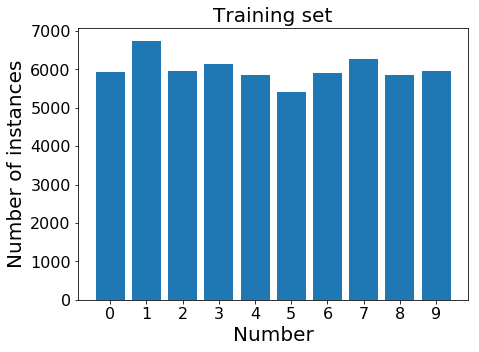

In [5]:
plt.figure(figsize=(7,5))
plt.bar(range(10), pd.Series(y_train).value_counts().sort_index(), tick_label=range(10))
plt.xlabel('Number')
plt.ylabel('Number of instances')
plt.title('Training set')
plt.show()

Label counts for test set:

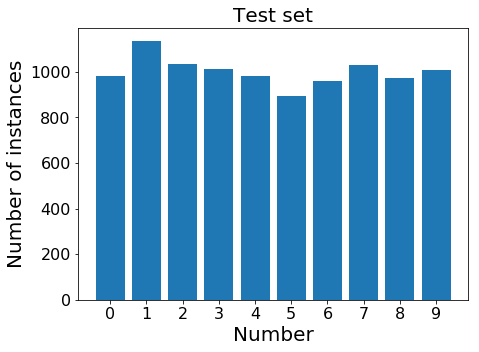

In [6]:
plt.figure(figsize=(7,5))
plt.bar(range(10), pd.Series(y_test).value_counts().sort_index(), tick_label=range(10))
plt.xlabel('Number')
plt.ylabel('Number of instances')
plt.title('Test set')
plt.show()

So we can see the labels are approximately balanced, which we wanted to be sure of so that our model does not learn any funny rules. Not very surprising that this is the case, since this is a standard dataset used for model testing purposes.


Let's take a look at some of the images:

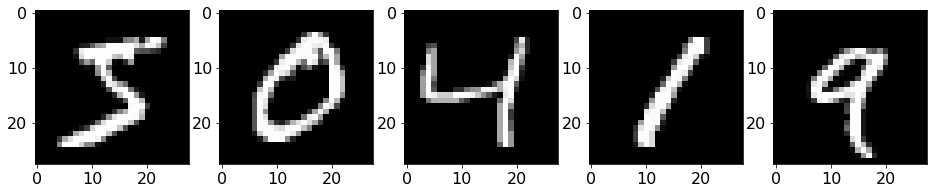

In [13]:
plt.figure(figsize=(16,4))
num_images = 5
for i in range(num_images):
    plt.subplot(1,num_images,i+1); 
    plt.imshow(x_train[i,:,:,0], cmap='gray')

Let's look at the training set dimensions:

In [6]:
print x_train.shape

(60000, 28, 28)


As we can see, the images are 28x28 pixels. However, they do not have a channel dimension, which they must for input to Keras convolutional layers.

In [9]:
x_train = x_train.reshape((60000,28,28,1))
x_test = x_test.reshape((10000,28,28,1))

In [10]:
print x_train.shape

(60000, 28, 28, 1)


And as we described earlier, we don't want a single variable output with 10 separate values (numbers 0 - 9). Instead, we want our output vector to have a probability for each digit. This means we need to one-hot encode our output vector. Luckily Keras has a built in method to do so:

In [13]:
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

In [14]:
y_train_enc = keras.utils.to_categorical(y_train)
y_test_enc = keras.utils.to_categorical(y_test)

In [20]:
y_train_enc[:20,:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Training the neural network

Here we start setting up the training parameters for the neural network. First we need the k samples we will take for each round of stochastic gradient descent, the mini-batch size.

In [ ]:
batch_size = 128

Below we using training generators, which allow us to potentially augment our images. We don't do that here, but the commented code would allow us to do so for our training set. Essentially, when we don't have a very large number of examples from a class, we can create additional training samples by flipping, stretching, zooming, rotating, etc. training examples we already have in our dataset. Here we do need to divide all our images by 255, the maximum possible pixel value for the MNIST dataset. Neural networks like to see smaller values, and without rescaling we usually will not be able to get a model to converge.

In [15]:
# train_datagen = ImageDataGenerator(
#         rotation_range=10,
#         rescale=1./255,
#         width_shift_range=0.0,
#         height_shift_range=0.0,
#         shear_range=0.0,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=False,
#         fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train,  
        y_train_enc,
        batch_size=batch_size)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow(
        x_test,
        y_test_enc,
        batch_size=batch_size)

### Convolutional neural network
Here we'll build up the layers of the convolutional neural network model.

Let's start with the small convolutional network from the Keras tutorial for classifying cats/dogs: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [19]:
### Model Architecture 1 ###
model_conv = Sequential()

model_conv.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Conv2D(32, (3, 3)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Conv2D(64, (3, 3)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Flatten())

model_conv.add(Dense(128))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.5))

model_conv.add(Dense(10))
model_conv.add(Activation('softmax'))

model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [21]:
history = model_conv.fit_generator(train_generator, x_train.shape[0] // batch_size, \
                                    epochs=100, verbose=1, validation_data=(x_test, y_test_enc))

Epoch 1/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0190 - acc: 0.9936 - val_loss: 0.8724 - val_acc: 0.9455
Epoch 2/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0205 - acc: 0.9937 - val_loss: 0.7352 - val_acc: 0.9542
Epoch 3/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0183 - acc: 0.9941 - val_loss: 0.8390 - val_acc: 0.9475
Epoch 4/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0161 - acc: 0.9949 - val_loss: 0.6790 - val_acc: 0.9574
Epoch 5/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0141 - acc: 0.9957 - val_loss: 0.8649 - val_acc: 0.9458
Epoch 6/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0129 - acc: 0.9956 - val_loss: 0.5849 - val_acc: 0.9635
Epoch 7/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0159 - acc: 0.9948 - val_loss: 0.7042 - val_acc: 0.9561
Epoch 8/100
468/468 [==============================] - 5s 10ms

Epoch 62/100
468/468 [==============================] - 4s 10ms/step - loss: 0.0050 - acc: 0.9986 - val_loss: 2.0701 - val_acc: 0.8713
Epoch 63/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0037 - acc: 0.9991 - val_loss: 2.1680 - val_acc: 0.8650
Epoch 64/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0057 - acc: 0.9984 - val_loss: 1.5770 - val_acc: 0.9020
Epoch 65/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0055 - acc: 0.9984 - val_loss: 1.4593 - val_acc: 0.9093
Epoch 66/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0053 - acc: 0.9986 - val_loss: 1.7094 - val_acc: 0.8936
Epoch 67/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0043 - acc: 0.9988 - val_loss: 1.6635 - val_acc: 0.8966
Epoch 68/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0045 - acc: 0.9987 - val_loss: 1.9615 - val_acc: 0.8781
Epoch 69/100
468/468 [==============================] -

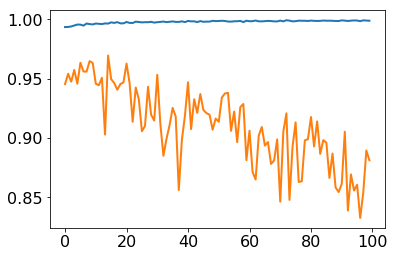

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [27]:
pd.DataFrame(history.history).to_csv('./models/model_architecture_1.csv', index=True)
model_conv.save_weights('./models/model_architecture_1.h5')

In [28]:
### Model Architecture 2 ###
model_conv = Sequential()

model_conv.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Conv2D(64, (3, 3)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Flatten())

model_conv.add(Dense(128))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.5))

model_conv.add(Dense(10))
model_conv.add(Activation('softmax'))

model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [29]:
history = model_conv.fit_generator(train_generator, x_train.shape[0] // batch_size, \
                                    epochs=100, verbose=1, validation_data=(x_test, y_test_enc))
model_conv.save_weights('./models/model_architecture_2.h5')
pd.DataFrame(history.history).to_csv('./models/model_architecture_2.csv', index=True)

Epoch 1/100
468/468 [==============================] - 5s 11ms/step - loss: 0.2954 - acc: 0.9081 - val_loss: 0.3152 - val_acc: 0.9801
Epoch 2/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0984 - acc: 0.9709 - val_loss: 0.2486 - val_acc: 0.9844
Epoch 3/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0727 - acc: 0.9784 - val_loss: 0.1928 - val_acc: 0.9879
Epoch 4/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0577 - acc: 0.9836 - val_loss: 0.1799 - val_acc: 0.9888
Epoch 5/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0504 - acc: 0.9847 - val_loss: 0.1943 - val_acc: 0.9878
Epoch 6/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0450 - acc: 0.9869 - val_loss: 0.1632 - val_acc: 0.9898
Epoch 7/100
468/468 [==============================] - 4s 10ms/step - loss: 0.0387 - acc: 0.9884 - val_loss: 0.1489 - val_acc: 0.9906
Epoch 8/100
468/468 [==============================] - 4s 10ms/ste

Epoch 62/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0038 - acc: 0.9988 - val_loss: 0.3383 - val_acc: 0.9789
Epoch 63/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0044 - acc: 0.9986 - val_loss: 0.2554 - val_acc: 0.9841
Epoch 64/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0048 - acc: 0.9984 - val_loss: 0.3148 - val_acc: 0.9804
Epoch 65/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0063 - acc: 0.9981 - val_loss: 0.2717 - val_acc: 0.9830
Epoch 66/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0045 - acc: 0.9985 - val_loss: 0.4354 - val_acc: 0.9729
Epoch 67/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0047 - acc: 0.9987 - val_loss: 0.3649 - val_acc: 0.9773
Epoch 68/100
468/468 [==============================] - 5s 10ms/step - loss: 0.0052 - acc: 0.9983 - val_loss: 0.2867 - val_acc: 0.9822
Epoch 69/100
468/468 [==============================] -

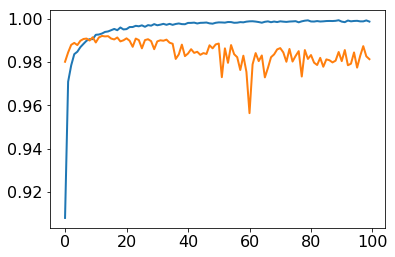

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [31]:
### Model Architecture 3 ###
model_conv = Sequential()

model_conv.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

model_conv.add(Conv2D(64, (3, 3)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Flatten())

model_conv.add(Dense(128))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.5))

model_conv.add(Dense(10))
model_conv.add(Activation('softmax'))

model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [32]:
history = model_conv.fit_generator(train_generator, x_train.shape[0] // batch_size, \
                                    epochs=100, verbose=1, validation_data=(x_test, y_test_enc))
model_conv.save_weights('./models/model_architecture_3.h5')
pd.DataFrame(history.history).to_csv('./models/model_architecture_3.csv', index=True)

Epoch 1/100
468/468 [==============================] - 4s 9ms/step - loss: 0.3603 - acc: 0.8886 - val_loss: 0.4256 - val_acc: 0.9733
Epoch 2/100
468/468 [==============================] - 4s 9ms/step - loss: 0.1245 - acc: 0.9632 - val_loss: 0.2866 - val_acc: 0.9821
Epoch 3/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0916 - acc: 0.9728 - val_loss: 0.2374 - val_acc: 0.9851
Epoch 4/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0751 - acc: 0.9778 - val_loss: 0.2196 - val_acc: 0.9862
Epoch 5/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0646 - acc: 0.9807 - val_loss: 0.2386 - val_acc: 0.9852
Epoch 6/100
468/468 [==============================] - 4s 8ms/step - loss: 0.0566 - acc: 0.9828 - val_loss: 0.1702 - val_acc: 0.9892
Epoch 7/100
468/468 [==============================] - 4s 8ms/step - loss: 0.0508 - acc: 0.9845 - val_loss: 0.1790 - val_acc: 0.9885
Epoch 8/100
468/468 [==============================] - 4s 9ms/step - 

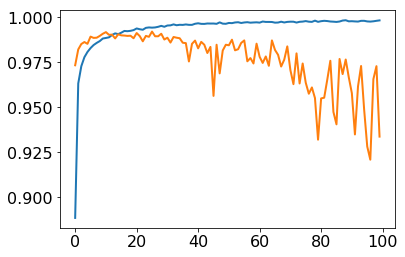

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [34]:
### Model Architecture 4 ###
model_conv = Sequential()

model_conv.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

model_conv.add(Conv2D(64, (3, 3)))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

model_conv.add(Flatten())

model_conv.add(Dense(128))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.5))

model_conv.add(Dense(10))
model_conv.add(Activation('softmax'))

model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [35]:
history = model_conv.fit_generator(train_generator, x_train.shape[0] // batch_size, \
                                    epochs=100, verbose=1, validation_data=(x_test, y_test_enc))
model_conv.save_weights('./models/model_architecture_4.h5')
pd.DataFrame(history.history).to_csv('./models/model_architecture_4.csv', index=True)

Epoch 1/100
468/468 [==============================] - 5s 10ms/step - loss: 0.3607 - acc: 0.8865 - val_loss: 0.3992 - val_acc: 0.9749
Epoch 2/100
468/468 [==============================] - 4s 9ms/step - loss: 0.1233 - acc: 0.9628 - val_loss: 0.2535 - val_acc: 0.9840
Epoch 3/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0896 - acc: 0.9727 - val_loss: 0.2226 - val_acc: 0.9861
Epoch 4/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0783 - acc: 0.9767 - val_loss: 0.1968 - val_acc: 0.9876
Epoch 5/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0671 - acc: 0.9794 - val_loss: 0.1756 - val_acc: 0.9890
Epoch 6/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0595 - acc: 0.9822 - val_loss: 0.1665 - val_acc: 0.9895
Epoch 7/100
468/468 [==============================] - 4s 9ms/step - loss: 0.0569 - acc: 0.9826 - val_loss: 0.1334 - val_acc: 0.9916
Epoch 8/100
468/468 [==============================] - 4s 9ms/step -

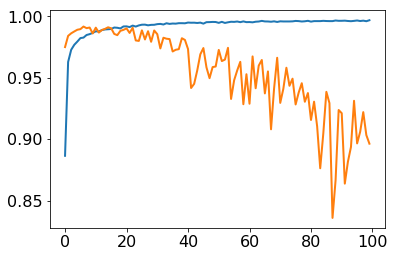

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [37]:
### Model Architecture 5 ###
model_conv = Sequential()

model_conv.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_conv.add(Conv2D(64, (3, 3), activation='relu'))
model_conv.add(Activation('relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))

model_conv.add(Flatten())

model_conv.add(Dense(128))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.5))

model_conv.add(Dense(10))
model_conv.add(Activation('softmax'))

model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [38]:
history = model_conv.fit_generator(train_generator, x_train.shape[0] // batch_size, \
                                    epochs=100, verbose=1, validation_data=(x_test, y_test_enc))
model_conv.save_weights('./models/model_architecture_5.h5')
pd.DataFrame(history.history).to_csv('./models/model_architecture_5.csv', index=True)

Epoch 1/100
468/468 [==============================] - 6s 13ms/step - loss: 0.2330 - acc: 0.9298 - val_loss: 0.3078 - val_acc: 0.9807
Epoch 2/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0842 - acc: 0.9755 - val_loss: 0.2064 - val_acc: 0.9872
Epoch 3/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0623 - acc: 0.9811 - val_loss: 0.1931 - val_acc: 0.9877
Epoch 4/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0524 - acc: 0.9837 - val_loss: 0.1665 - val_acc: 0.9894
Epoch 5/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0445 - acc: 0.9863 - val_loss: 0.1822 - val_acc: 0.9884
Epoch 6/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0383 - acc: 0.9881 - val_loss: 0.1591 - val_acc: 0.9899
Epoch 7/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0351 - acc: 0.9887 - val_loss: 0.1659 - val_acc: 0.9897
Epoch 8/100
468/468 [==============================] - 6s 12ms

Epoch 62/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0053 - acc: 0.9985 - val_loss: 0.1703 - val_acc: 0.9893
Epoch 63/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0068 - acc: 0.9981 - val_loss: 0.1840 - val_acc: 0.9885
Epoch 64/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.1902 - val_acc: 0.9882
Epoch 65/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0067 - acc: 0.9979 - val_loss: 0.4254 - val_acc: 0.9734
Epoch 66/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.2128 - val_acc: 0.9868
Epoch 67/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0055 - acc: 0.9982 - val_loss: 0.2354 - val_acc: 0.9853
Epoch 68/100
468/468 [==============================] - 6s 12ms/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.2079 - val_acc: 0.9871
Epoch 69/100
468/468 [==============================] -

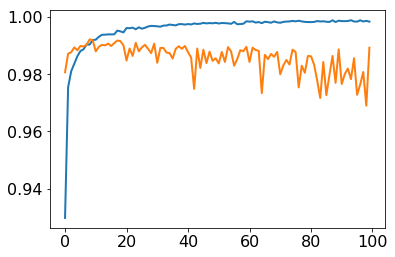

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [40]:
m1 = pd.read_csv('./mnist/models/model_architecture_1.csv')
m2 = pd.read_csv('./mnist/models/model_architecture_2.csv')
m3 = pd.read_csv('./mnist/models/model_architecture_3.csv')
m4 = pd.read_csv('./mnist/models/model_architecture_4.csv')
m5 = pd.read_csv('./mnist/models/model_architecture_5.csv')

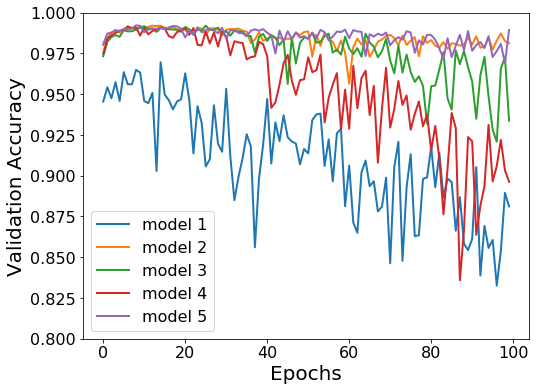

In [52]:
plt.figure(figsize=(8,6))
plt.plot(m1.index, m1.val_acc)
plt.plot(m2.index, m2.val_acc)
plt.plot(m3.index, m3.val_acc)
plt.plot(m4.index, m4.val_acc)
plt.plot(m5.index, m5.val_acc)
plt.ylim([0.8,1.0])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(['model 1', 'model 2', 'model 3', 'model 4', 'model 5'])
plt.show()

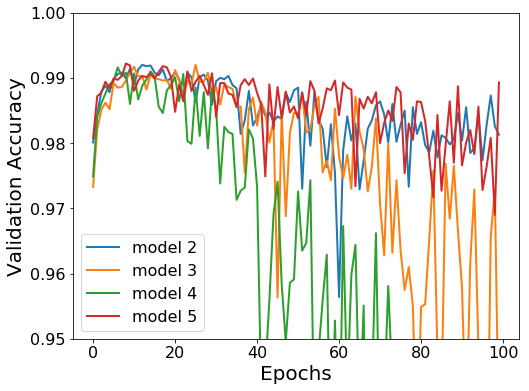

In [53]:
plt.figure(figsize=(8,6))
plt.plot(m2.index, m2.val_acc)
plt.plot(m3.index, m3.val_acc)
plt.plot(m4.index, m4.val_acc)
plt.plot(m5.index, m5.val_acc)
plt.ylim([0.95,1.0])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(['model 2', 'model 3', 'model 4', 'model 5'])
plt.show()